<img src= "https://mar.prod.image.rndtech.de/var/storage/images/haz/nachrichten/wirtschaft/niedersachsen/diese-vw-plattform-soll-autoscout24-und-mobile.de-angreifen/640945376-1-ger-DE/Diese-VW-Plattform-soll-Autoscout24-angreifen_master_reference.jpg">

# [SF_DST-27] Project 6. Car Price prediction 

## Task:
**to create a model that will predict the value of a used car based on its characteristics**

**The training dataset is a sample of data from the www.auto.ru is actual on Aug.24, 2021, which includes all major car models produced in the period from 1990 to 2021 and are selling within a radius of 200 km around Moscow**

In [1]:
import pandas as pd
import numpy as np
import re
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from tqdm import tqdm
from itertools import combinations
from scipy.stats import ttest_ind
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None

import os


In [2]:
#pip install -U seaborn

In [3]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
VAL_SIZE   = 0.20
CURRENT_DATE = pd.Timestamp.today()

'pip' is not recognized as an internal or external command,
operable program or batch file.


### Functions definition

In [4]:

def check_df_before_merg(d_df1,d_df2):
    ''' the function to compare of data types both datasets
    was copied from SF colleagues'''

    list_of_names1 = list(d_df1.columns)
    temp_dict = {}
    temp_dict['feature_train'] = list_of_names1
    temp_dict['type_train'] = d_df1.dtypes
    temp_dict['sample_train'] = d_df1.loc[5].values
    temp_df1 = pd.DataFrame.from_dict(temp_dict)


    list_of_names2 = list(d_df2.columns)
    temp_dict2 = {}
    temp_dict2['feature_test'] = list_of_names2
    temp_dict2['type_test'] = d_df2.dtypes
    temp_dict2['sample_test'] = d_df2.loc[5].values
    temp_df2 = pd.DataFrame.from_dict(temp_dict2)

    temp_insert = pd.DataFrame(columns=['< - >'])

    temp_df = pd.concat([temp_df1,temp_insert, temp_df2], axis=1, sort=False)
    temp_df.reset_index(inplace = True)
    del temp_df['index']
    temp_df['< - >'] = '| - |'
    display(temp_df)

    temp_dict3 = {}
    temp_df3= pd.DataFrame(temp_df)
    temp_list  = []
    temp_list2  = []
    temp_list3  = []
    temp_list4  = []


    for i in range(len(temp_df)):
        if str(temp_df3['type_train'][i]) != str(temp_df3['type_test'][i]):
            temp_list.append(temp_df3['feature_train'][i])
            temp_list2.append(temp_df3['feature_test'][i])
            temp_list3.append(str(temp_df3['type_train'][i]) + ' != ' + str(temp_df3['type_test'][i]))
            temp_list4.append(i)

    temp_dict3['index']= temp_list4
    temp_dict3['feature_train']= temp_list
    temp_dict3['divergences'] = temp_list3
    temp_dict3['feature_test']= temp_list2

    temp_df4 = pd.DataFrame.from_dict(temp_dict3)
    temp_df4.set_index('index',inplace=True)

    print(f'The data types are different in {len(temp_df4)} columns\n')
    display(temp_df4)

In [5]:
def clean_smb(smb):
    ''' the function does remove the symbols
    in the string data'''

    smb = smb.replace("}",'')
    smb = smb.replace("{",'')
    smb = smb.replace("]",'')
    smb = smb.replace("]",'')
    smb = smb.replace('"','')
    smb = smb.strip('[]')
    smb = smb.split(',')
    return smb

In [6]:
def float_value(feature):
    ''' The function cleans the digits from other 
    symbols and brings them to float'''
    
    pattern = re.compile('([^\d.]+)')
    feature = feature.replace(pattern, '')
    oft_value = feature.value_counts(sort=True).keys()[0]
    feature = feature.replace('', oft_value).astype(float, errors = 'raise')
    return feature

In [7]:
def cat_feature_overview(feature):
    ''' The function outputs the feature's info'''
    
    print(f'Total lines: {len(feature)}')
    print(f'Data types: {feature.dtypes}')
    print(f'Total values: {feature.count()}')
    print(f'The most frequent value: {feature.value_counts(sort=True).keys()[0]}')
    print(f'The less frequent value: {feature.value_counts(sort=True).keys()[-1]}')
    print(f'Unique values: {feature.nunique()}')
    print(f'Missing values: {feature.isna().sum()}')
    sns.countplot(y = feature, order = feature.value_counts(sort=True).index)

    return


In [8]:
def num_feature_overview(feature):
    ''' The function outputs the feature's info'''
    
    print(f'Total lines: {len(feature)}')
    print(f'Data types: {feature.dtypes}')
    print(f'Total values: {feature.count()}')
    print(f'The most frequent value: {feature.value_counts(sort=True).keys()[0]}')
    print(f'The less frequent value: {feature.value_counts(sort=True).keys()[-1]}')
    print(f'Unique values: {feature.nunique()}')
    print(f'Missing values: {feature.isna().sum()}')

    return

In [9]:
def subset_by_iqr(feature, whisker_width=1.5):
    '''Remove outliers from a dataframe by column, including optional
       whiskers, removing rows for which the column value are
       less than Q1-1.5IQR or greater than Q3+1.5IQR.
    '''
    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)
    iqr = q3 - q1
    low_outlier = q1 - whisker_width*iqr
    high_outlier = q3 + whisker_width*iqr
    column_median = feature.median()

    # Apply filter with respect to IQR, including optional whiskers
    # else mode()

    return feature.apply(lambda x: x if (x > low_outlier and x < high_outlier) else column_median)

In [10]:
def check_iqr(feature, whisker_width=1.5):
    '''defines the quantiles at the column, including optional
       whiskers with Q1-1.5IQR and Q3+1.5IQR boarders.
    '''
    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)
    iqr = q3 - q1
    low_outlier = q1 - whisker_width*iqr
    high_outlier = q3 + whisker_width*iqr
    IQRs = pd.DataFrame({'Q1' : [q1], 'Q3' : [q3], 'IQR' : [iqr], 'low_outlier' : [low_outlier], 'high_outlier' : [high_outlier]})
    
    sns.set_style("darkgrid")


    # feature's distribution
    x = feature
    plt.figure(figsize=(10,5))
    sns.distplot(x, kde=True)
    plt.axvline(low_outlier, color='red')
    plt.axvline(high_outlier, color='red')
    plt.axvline(q1, color='blue',linestyle='--')
    plt.axvline(q3, color='blue',linestyle='--')
    plt.show()
    

    return IQRs

In [11]:
def train_brand_pvt(val_body_type, from_year,  to_year, i=0):
    
    model_tbl= train[(train['bodyType'] == val_body_type) & (train['modelDate'].between(from_year, to_year))].pivot_table(values= 'price', index= 'brand', aggfunc= 'std')
    std_n = model_tbl['price']
    low_std = std_n / 1.5
    high_std = std_n * 1.5
    model_tbl['low_std'] = round(low_std,2)
    model_tbl['std_n'] = round(std_n,2)
    model_tbl['high_std'] = round(high_std,2)
    model_tbl.drop(['price'], axis = 1, inplace = True)
    low_std_avg = model_tbl.low_std.mean()
    high_std_avg = model_tbl.high_std.mean()
    model_tbl = model_tbl[(model_tbl['std_n'] >= low_std_avg) & (model_tbl['std_n'] <=  high_std_avg)].reset_index()
    display(model_tbl)
    act_model_lst = model_tbl['brand'].to_list()
    print(f'The most relevant brands sorted by body type "{val_body_type}" in time period from {from_year} to {to_year}','\n', act_model_lst,'\n')
 
    
    return act_model_lst

In [12]:
def metrics_func(y_true, y_pred):
    
    #Mean Absolute Error
    mae = metrics.mean_absolute_error(y_true, y_pred)

    #Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    
    #Symmetric Mean Absolute Percentage Error
    smape = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

    #Mean Squared Error*
    mse = metrics.mean_squared_error(y_true, y_pred)

    #Root Mean Squared Error
    rmse = np.sqrt(mse)
    
    #Coefficient of determination
    R_2 = metrics.r2_score(y_true, y_pred)
    

    print(f'MAE Mean Absolute Error {mae}')
    print(f'MAPE  Mean Absolute Percentage Error {mape}%')
    print(f'SMAPE Symmetric Mean Absolute Percentage Error {smape}%')
    print(f'MSE Mean Squared Error {mse}')
    print(f'RMSE Root Mean Squared Error {rmse}')
    print(f'R_2 Coefficient of determination {R_2}')
    
    return


# 1. DATA
## 1.1 Import of data

In [13]:
#PATH_to_file = '/kaggle/input/sf-dst-car-price-prediction/'
#PATH_to_file_data = '/kaggle//input/20210824-auto-ru-train-dataset/'

In [14]:
#train = pd.read_csv(PATH_to_file_data +'2021-08-29_train.csv')
#test = pd.read_csv(PATH_to_file+'test.csv')
#submit = pd.read_csv(PATH_to_file+'sample_submission.csv')

train = pd.read_csv('2021-08-29_train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('sample_submission.csv')

pd.set_option('display.max_columns', None)
print('Training dataset shape: ', train.shape)
display(train.head(3))
print('Testing dataset shape: ', test.shape)
display(test.head(3))
print('Submission shape: ', submit.shape)
display(submit.head(2))

Training dataset shape:  (59762, 32)


,Unnamed: 0,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,price,priceCurrency,productionDate,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,0,внедорожник 5 дв.,ALFA_ROMEO,коричневый,{'id': '0'},Мы предлагаем Вам сформированные индивидуальны...,2.0,200,"{'asr': True, 'airbag-driver': True, 'aux': Tr...",бензин,//avatars.mds.yandex.net/get-autoru-vos/447689...,69720,2016,"{'code': 'STELVIO', 'name': 'Stelvio', 'ru_nam...",Stelvio,2.0 AT (200 л.с.) 4WD,5,1629806291,3250000,RUR,2017,"{'id': '20908618', 'year_from': 2016, 'price_s...","2.0 AT (200 л.с.), внедорожник, полный, бензин",автоматическая,EUROPEAN,2,12.0,Оригинал,полный,Левый,Не требует ремонта,Растаможен
1,1,седан,ALFA_ROMEO,чёрный,{'id': '0'},Мы предлагаем Вам сформированные индивидуальны...,2.0,280,"{'asr': True, 'airbag-driver': True, 'usb': Tr...",бензин,//avatars.mds.yandex.net/get-autoru-vos/530062...,38469,2015,"{'code': 'GIULIA', 'name': 'Giulia', 'ru_name'...",Giulia,2.0 AT (280 л.с.) 4WD,4,1629806291,2350000,RUR,2016,"{'id': '20728074', 'name': 'II (952)', 'ru_nam...","2.0 AT (280 л.с.), седан, полный, бензин",автоматическая,EUROPEAN,1,12.0,Оригинал,полный,Левый,Не требует ремонта,Растаможен
2,2,хэтчбек 5 дв.,ALFA_ROMEO,красный,{'id': '0'},Мы предлагаем Вам сформированные индивидуальны...,1.4,170,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,//avatars.mds.yandex.net/get-autoru-vos/412107...,97352,2010,"{'code': 'GIULIETTA', 'name': 'Giulietta', 'ru...",Giulietta,1.4 AMT (170 л.с.),5,1629806291,1052000,RUR,2014,"{'id': '8484175', 'name': 'III', 'ru_name': '3...","1.4 AMT (170 л.с.), хэтчбек 5 дв., передний, б...",вариатор,EUROPEAN,1,12.0,Оригинал,передний,Левый,Не требует ремонта,Растаможен


Testing dataset shape:  (34686, 32)


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


Submission shape:  (34686, 2)


,sell_id,price
0,1100575026,0
1,1100549428,0


In [15]:
submit.head(3)

,sell_id,price
0,1100575026,0
1,1100549428,0
2,1100658222,0



### Features
 nn |Features| Description | Type 
----|---|----|---
0   |bodyType| Car's body type | Categorical
1   |brand | Car's brand | Categorical
2   |color | Color | Categorical
3   |color_hex  | Color hex code| Categorical
4   |complectation_dic| Dict of complectation | Categorical
5   |description | Description by seller | Categorical
6   |engineDisplacement | Displacement of engine | Quantitative
7   |enginePower | Power of engine | Quantitative
8   |equipment_dict | Dict of equipment | Categorical
9   |fuelType | Type of fuel | Categorical
10  |image | Image of the car | Categorical
11  |mileage | Mileage of the car | Quantitative
12  |modelDate | Year of car's model| Ordinal
13  |model_info | Code of car's model | Categorical
14  |model_name | Name of car's model | Categorical
15  |name | Summary data | Categorical
16  |numberOfDoors | Number of doors | Quantitative
17  |parsing_unixtime | Time of parsing | Ordinal
18  |price | Offered price | Quantitative
19  |priceCurrency | Currency | Quantitative
20  |productionDate | Date of production | Ordinal
21  |sell_id | Seller's ID | Ordinal
22  |super_gen | Dict of features | Categorical
23  |vehicleConfiguration | Dict of options | Categorical
24  |vehicleTransmission | Transmission | Categorical
25  |vendor | Vendor | Categorical
26  |Владельцы | Number of owners | Quantitative
27  |Владение | Holding period month | Quantitative
28  |ПТС | Original vehicle registration | Binary
29  |Привод | Gear type| Categorical
30  |Руль | Steering wheel | Categorical
31  |Состояние | Accident-free car | Binary
32  |Таможня | Custom cleared | Binary




## 1.2 Data validation and training dataset matching with test sample 

In [16]:
# comparison of training and test datasets
check_df_before_merg(train, test)

,feature_train,type_train,sample_train,< - >,feature_test,type_test,sample_test
0,Unnamed: 0,int64,5,| - |,NaN,NaN,NaN
1,bodyType,object,хэтчбек 5 дв.,| - |,bodyType,object,лифтбек
2,brand,object,ALFA_ROMEO,| - |,brand,object,SKODA
3,color,object,белый,| - |,color,object,серый
4,complectation_dict,object,{'id': '0'},| - |,complectation_dict,object,"{""id"":""5011515"",""name"":""RS"",""available_options..."
5,description,object,РОЛЬФ Алтуфьево — это целых 30 лет успешной по...,| - |,description,object,Продаю свой автомобиль! Автомобиль полностью и...
6,engineDisplacement,float64,1.4,| - |,engineDisplacement,object,2.0 LTR
7,enginePower,int64,170,| - |,enginePower,object,200 N12
8,equipment_dict,object,"{'cruise-control': True, 'asr': True, 'esp': T...",| - |,equipment_dict,object,"{""cruise-control"":true,""tinted-glass"":true,""es..."
9,fuelType,object,бензин,| - |,fuelType,object,бензин


The data types are different in 8 columns



,feature_train,divergences,feature_test
index,,,
0,Unnamed: 0,int64 != nan,NaN
6,engineDisplacement,float64 != object,engineDisplacement
7,enginePower,int64 != object,enginePower
18,price,int64 != nan,NaN
25,Владельцы,int64 != object,Владельцы
26,Владение,float64 != object,Владение
32,NaN,nan != object,car_url
33,NaN,nan != int64,sell_id


In [17]:
#the feature Unnamed: 0 isn't in test dataset.
# Unnamed column has no information
train.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [18]:
#in train dataset are not the features 'sell_id','car_url'.
#meaning that they don't have any useful for our model information
#drop these features
test.drop(['sell_id','car_url'], axis = 1, inplace=True)

In [19]:
test['price'] = float(0)

In [20]:
train['price'] = train.price.astype(float)


* assign for the testing dataset as 'sample' = 0
* assign for the training dataset as 'sample' = 1

In [21]:
test['sample'] = 0
train['sample'] = 1
print(f'The training dataset with {train.shape} and testing dataset with {test.shape} can be combined')

The training dataset with (59762, 32) and testing dataset with (34686, 32) can be combined


In [22]:
# comparison of training and test datasets
check_df_before_merg(train, test)

,feature_train,type_train,sample_train,< - >,feature_test,type_test,sample_test
0,bodyType,object,хэтчбек 5 дв.,| - |,bodyType,object,лифтбек
1,brand,object,ALFA_ROMEO,| - |,brand,object,SKODA
2,color,object,белый,| - |,color,object,серый
3,complectation_dict,object,{'id': '0'},| - |,complectation_dict,object,"{""id"":""5011515"",""name"":""RS"",""available_options..."
4,description,object,РОЛЬФ Алтуфьево — это целых 30 лет успешной по...,| - |,description,object,Продаю свой автомобиль! Автомобиль полностью и...
5,engineDisplacement,float64,1.4,| - |,engineDisplacement,object,2.0 LTR
6,enginePower,int64,170,| - |,enginePower,object,200 N12
7,equipment_dict,object,"{'cruise-control': True, 'asr': True, 'esp': T...",| - |,equipment_dict,object,"{""cruise-control"":true,""tinted-glass"":true,""es..."
8,fuelType,object,бензин,| - |,fuelType,object,бензин
9,image,object,//avatars.mds.yandex.net/get-autoru-vos/392674...,| - |,image,object,https://avatars.mds.yandex.net/get-autoru-vos/...


The data types are different in 4 columns



,feature_train,divergences,feature_test
index,,,
5,engineDisplacement,float64 != object,engineDisplacement
6,enginePower,int64 != object,enginePower
24,Владельцы,int64 != object,Владельцы
25,Владение,float64 != object,Владение


In [23]:
# Merging
df = test.append(train, sort=False).reset_index(drop=True)
print(f'the shape of the merged dataset is {df.shape}')

the shape of the merged dataset is (94448, 32)


In [24]:
df.sample(2)

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,sample
19267,компактвэн,TOYOTA,серый,NaN,Безопасность: 6. Салон: 5. Мультимедиа: 2. Ком...,1.8 LTR,147 N12,"{""airbag-rear-side"":true,""asr"":true,""leather-g...",бензин,https://autoru.naydex.net/LxPU17803/f5b8d77S/u...,132032,2009,"{""code"":""VERSO"",""name"":""Verso"",""ru_name"":""Верс...",VERSO,1.8 CVT (147 л.с.),5,1603287257,RUB,2010,"{""id"":""20389524"",""displacement"":1798,""engine_t...",COMPACTVAN VARIATOR 1.8,вариатор,JAPANESE,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0
32592,внедорожник 5 дв.,NISSAN,чёрный,NaN,Преимущества этого автомобиля:\n*ПРОИЗВЕДЕНА П...,2.5 LTR,170 N12,"{""adaptive-light"":true,""isofix"":true,""electro-...",бензин,https://autoru.naydex.net/1xsMU7627/eea2057RFg...,91000,2010,"{""code"":""X_TRAIL"",""name"":""X-Trail"",""ru_name"":""...",X_TRAIL,2.5 CVT (170 л.с.) 4WD,5,1603603913,RUB,2012,"{""id"":""21117554"",""displacement"":2488,""engine_t...",ALLROAD_5_DOORS VARIATOR 2.5,вариатор,JAPANESE,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0.0,0


# 2. Data cleaning and Exploratory Data Analysis (EDA)


## 2.1 Pandas profiling analyse

In [25]:
#pandas_profiling.ProfileReport(df)

#### Profiling summary
* _30 not treated features in the dataset:_
    * _CAT	21_
    * _NUM	6_
    * _UNSUPPORTED	4_ 
    * _BOOL	1_
* _Missing cells (%)	2.2%_
* _Duplicate rows (%)	0.0%_
* _'Состояние','Таможня','priceCurrency',  are constant values and there is no sense for any further treatment._ _They are being droped._
* _'car url' can give no information directly and doesn't matter for the prediction model._
* _'image' can give no information directla and doesn'matter for the prediction model._
* _'super gen' contains a lot of technical information, however the test data set doesn't contain the data in the feature._
* _'sell id' doesn't contain any useful information._
* _'vehicleConfiguration' duplicates the information are provided by other features._
* _'description' doesn't contains useful information._
* _'model info duplicates the information are provided by other features._
* _'equipment_dict' and 'complectation_dict' have a similar data and can be merged._

## 2.2 Features analysis

In [26]:
df.columns

Index(['bodyType', 'brand', 'color', 'complectation_dict', 'description',
       'engineDisplacement', 'enginePower', 'equipment_dict', 'fuelType',
       'image', 'mileage', 'modelDate', 'model_info', 'model_name', 'name',
       'numberOfDoors', 'parsing_unixtime', 'priceCurrency', 'productionDate',
       'super_gen', 'vehicleConfiguration', 'vehicleTransmission', 'vendor',
       'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние',
       'Таможня', 'price', 'sample'],
      dtype='object')

In [27]:
# droping the useless features
df.drop(['Состояние', 'Таможня', 'priceCurrency', 'image', 'super_gen',
         'vehicleConfiguration', 'description', 'model_info', 'parsing_unixtime'], axis = 1, inplace=True)

In [28]:
df.shape

(94448, 23)

### 2.2.1 bodyType

Total lines: 94448
Data types: object
Total values: 94447
The most frequent value: седан
The less frequent value: фастбек
Unique values: 25
Missing values: 1


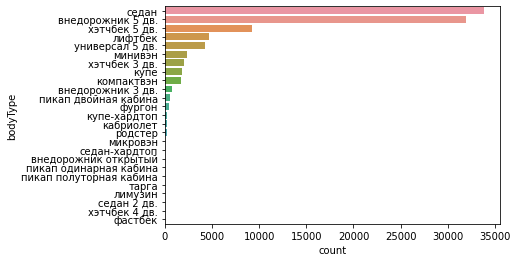

In [29]:
#show the feature's info
cat_feature_overview(df.bodyType)

In [30]:
#filling up by mode
df['bodyType'] = df.bodyType.fillna(df.bodyType.value_counts(sort=True).keys()[0])

In [31]:
#Dropping the bodyTypes features that are not in the test dataset
test_bodyType_lst = test.bodyType.value_counts().keys()
df = df[(df['bodyType'].isin(test_bodyType_lst))]
df.shape

(94442, 23)

In [32]:
df[(df['sample'] == 0)].shape

(34686, 23)

In [33]:
# 10 most popular car bodies from test dataset
test_bodies_10 = test.bodyType.value_counts(sort=True).keys()[:10]
test_bodies_10

Index(['седан', 'внедорожник 5 дв.', 'лифтбек', 'хэтчбек 5 дв.',
       'универсал 5 дв.', 'минивэн', 'купе', 'компактвэн', 'хэтчбек 3 дв.',
       'пикап двойная кабина'],
      dtype='object')

### 2.2.2 enginePower

In [34]:
num_feature_overview(df.enginePower)

Total lines: 94442
Data types: object
Total values: 94442
The most frequent value: 150
The less frequent value: 316 N12
Unique values: 710
Missing values: 0


In [35]:
df['enginePower'] = df['enginePower'].astype(str)
df['enginePower']  = df['enginePower'].apply(lambda x: x.partition('N12')[0]).astype(int)

In [36]:
num_feature_overview(df.enginePower)

Total lines: 94442
Data types: int32
Total values: 94442
The most frequent value: 150
The less frequent value: 176
Unique values: 406
Missing values: 0


<AxesSubplot:title={'center':'The cars with total power less then 90HP'}>

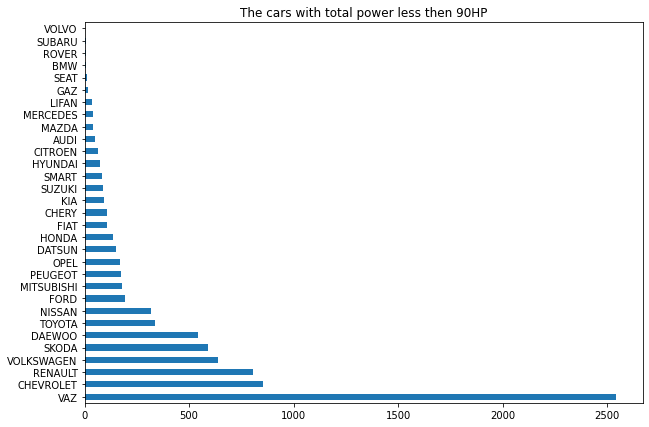

In [37]:
df[(df['enginePower']<90)]['brand'].value_counts().plot(kind = 'barh',figsize= (10,7), title='The cars with total power less then 90HP')

<AxesSubplot:title={'center':'The cars with total power over 600HP'}>

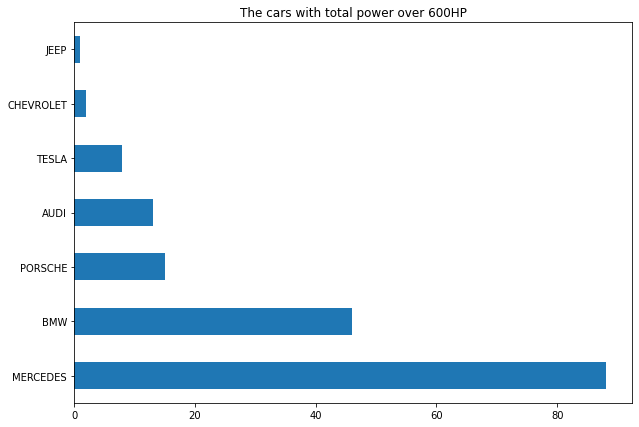

In [38]:
df[(df['enginePower']>600)]['brand'].value_counts().plot(kind = 'barh', figsize= (10,7),title='The cars with total power over 600HP')

c:\users\asyac\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='enginePower'>

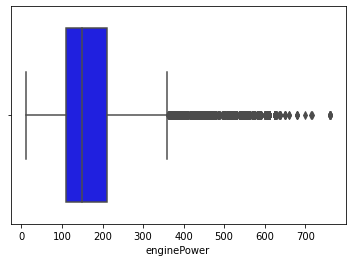

In [39]:
sns.boxplot(df.enginePower, color='blue')

c:\users\asyac\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


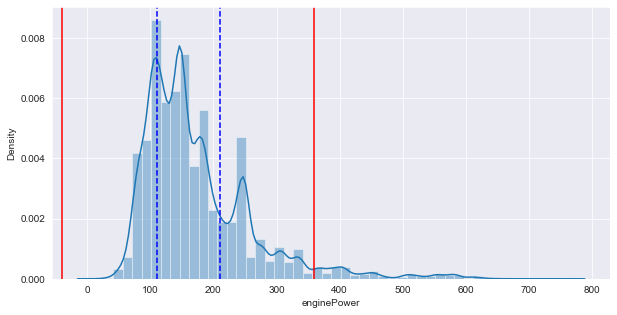

,Q1,Q3,IQR,low_outlier,high_outlier
0,110.0,210.0,100.0,-40.0,360.0


In [40]:
#Distribution of the enginePower before dropping of the outliers
check_iqr(df.enginePower)

c:\users\asyac\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='enginePower'>

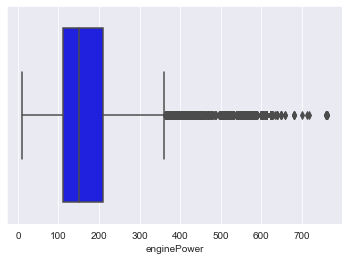

In [41]:
sns.boxplot(df.enginePower, color='blue')

In [42]:
#Dropping the lines with the outliers
df.drop(df[(df['sample'] ==1) & (df['enginePower'] > 360)].index, inplace=True)
df[(df['sample'] == 0)].shape

(34686, 23)

c:\users\asyac\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


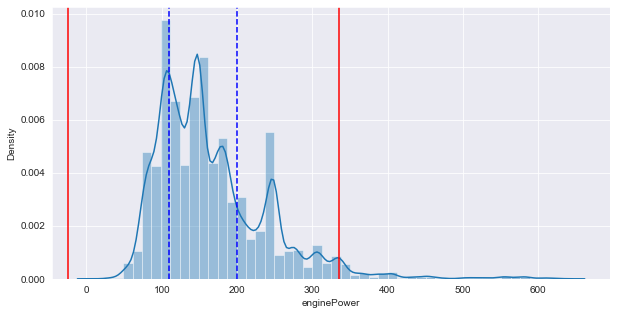

,Q1,Q3,IQR,low_outlier,high_outlier
0,110.0,200.0,90.0,-25.0,335.0


In [43]:
#Distribution of the enginePower after dropping of the outliers
check_iqr(df.enginePower)

### 2.2.3 modelDate

Total lines: 92039
Data types: int64
Total values: 92039
The most frequent value: 2010
The less frequent value: 1969
Unique values: 67
Missing values: 0


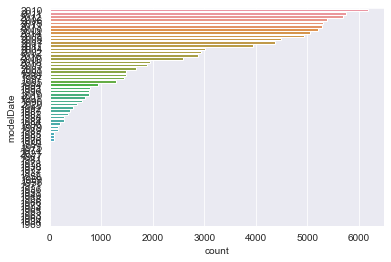

In [44]:
cat_feature_overview(df.modelDate)

c:\users\asyac\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


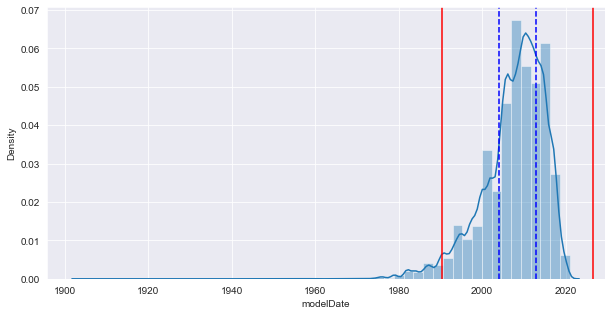

,Q1,Q3,IQR,low_outlier,high_outlier
0,2004.0,2013.0,9.0,1990.5,2026.5


In [45]:
#check the outliers 
check_iqr(df.modelDate)

In [46]:
df.modelDate.describe()

count    92039.000000
mean      2007.618596
std          7.482590
min       1904.000000
25%       2004.000000
50%       2009.000000
75%       2013.000000
max       2021.000000
Name: modelDate, dtype: float64

In [47]:
#Sampling the relevant modelDate year's range on train dataset

df.drop(df[(df['sample'] == 1) & (df.modelDate <= 1990) & (df.modelDate >= 2021)].index, inplace=True)
df[(df['sample'] == 0)].shape

(34686, 23)

### 2.2.4 productionDate

Total lines: 92039
Data types: int64
Total values: 92039
The most frequent value: 2012
The less frequent value: 1904
Unique values: 70
Missing values: 0


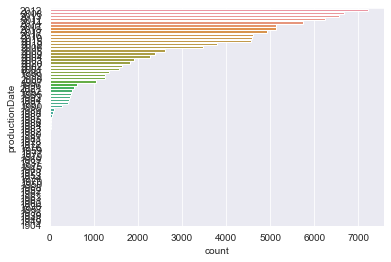

In [48]:
cat_feature_overview(df.productionDate)

c:\users\asyac\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


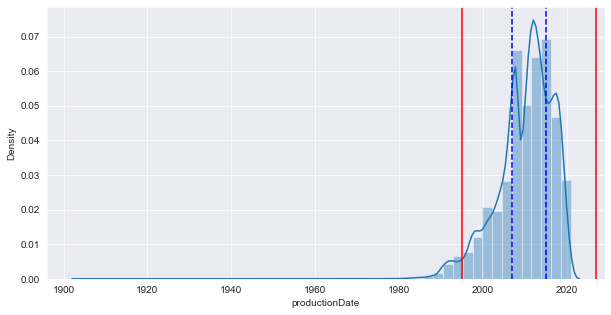

,Q1,Q3,IQR,low_outlier,high_outlier
0,2007.0,2015.0,8.0,1995.0,2027.0


In [49]:
#check the outliers distribution of the productionDate
check_iqr(df.productionDate)

In [50]:
df.productionDate.describe()

count    92039.000000
mean      2010.158650
std          6.655669
min       1904.000000
25%       2007.000000
50%       2011.000000
75%       2015.000000
max       2021.000000
Name: productionDate, dtype: float64

In [51]:
#Sampling the relevant productionDate year's range on train dataset
df.drop(df[(df['sample'] == 1) & (df.productionDate < 1995) & (df.productionDate > 2021)].index, inplace=True)
df[(df['sample'] == 0)].shape

(34686, 23)

c:\users\asyac\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


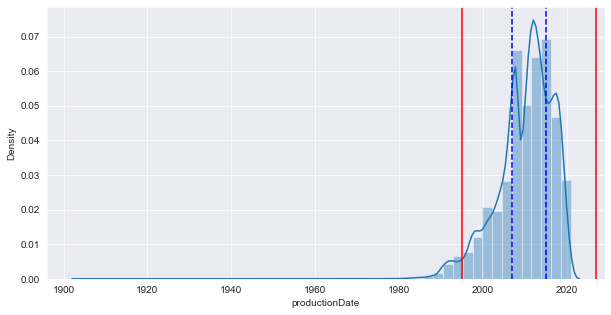

,Q1,Q3,IQR,low_outlier,high_outlier
0,2007.0,2015.0,8.0,1995.0,2027.0


In [52]:
#Distribution of the productionDate after dropping of the outliers
check_iqr(df.productionDate)

In [53]:
df.shape

(92039, 23)

### 2.2.5 target feature "price" at the train dataset

In [54]:
#info from prices of training dataset
num_feature_overview(df.price)

Total lines: 92039
Data types: float64
Total values: 92039
The most frequent value: 0.0
The less frequent value: 4440000.0
Unique values: 4783
Missing values: 0


c:\users\asyac\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


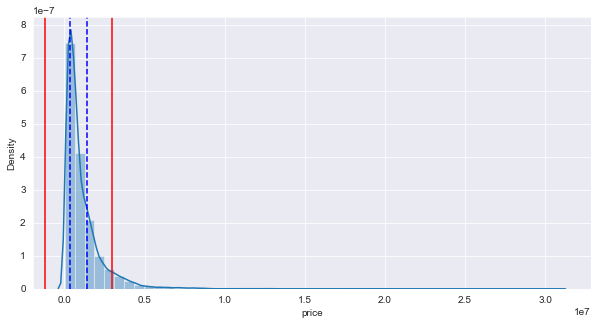

,Q1,Q3,IQR,low_outlier,high_outlier
0,355000.0,1400000.0,1045000.0,-1212500.0,2967500.0


In [55]:
check_iqr(df[(df['sample'] ==1)].price)

In [56]:
df[(df['sample'] ==1)].price.describe()

count    5.735300e+04
mean     1.096453e+06
std      1.226391e+06
min      2.000000e+04
25%      3.550000e+05
50%      7.000000e+05
75%      1.400000e+06
max      3.085000e+07
Name: price, dtype: float64

In [57]:
len(df[(df['price']> 3038000)])

3801

In [58]:
#dropping the higher outliered data in dataset
#df = df[((df['sample']==1) & (df['price']<3038000)) | (df['sample']==0)]

In [59]:
#For further modeling seems to be used a log-function of price feature
df['price_log']=df['price'].apply(lambda x: np.log(x+1))#to avoid df1['price_log'] = df1.price_log.fillna(0)

c:\users\asyac\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


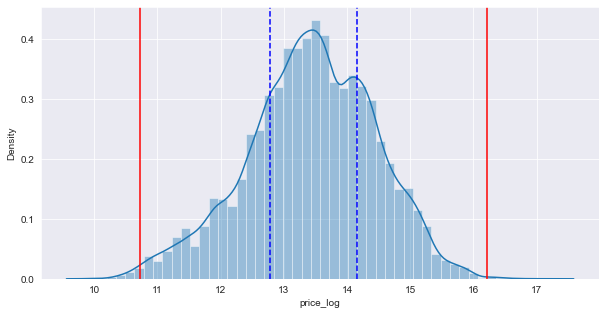

,Q1,Q3,IQR,low_outlier,high_outlier
0,12.779876,14.151984,1.372108,10.721714,16.210145


In [60]:
#check the feature's distribution
check_iqr(df[(df['sample'] ==1)].price_log)

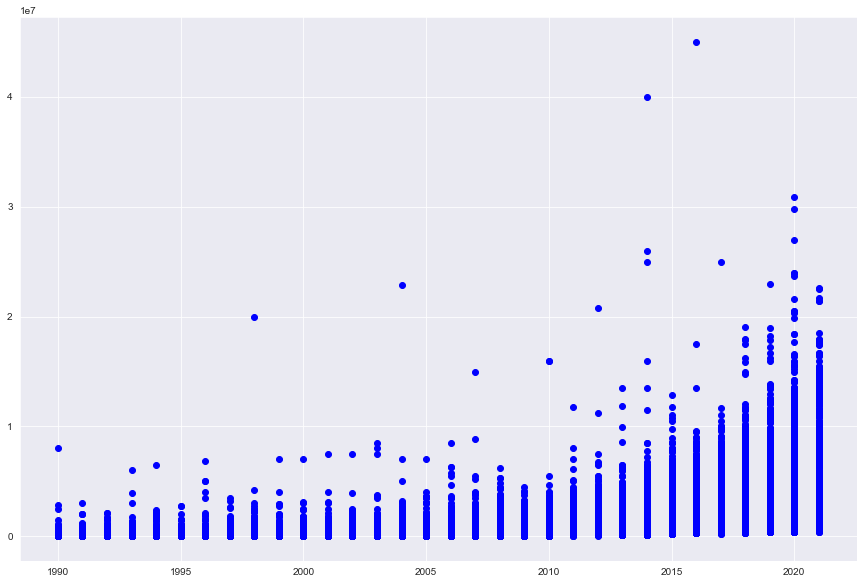

In [61]:
#The distribution car prices by production years on train dataset
year = train['productionDate'].values
price = train['price'].values
plt.figure(figsize=(15,10))
plt.scatter(year,price,c='b')

In [62]:
df[(df['sample'] == 0)].shape

(34686, 24)

### 2.2.6 brand

Total lines: 92039
Data types: object
Total values: 92039
The most frequent value: VOLKSWAGEN
The less frequent value: ISUZU
Unique values: 45
Missing values: 0


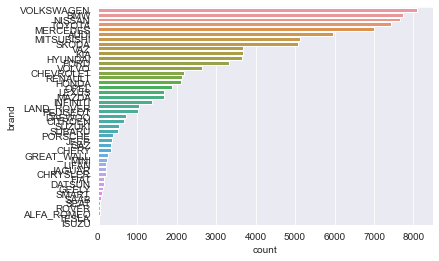

In [63]:
cat_feature_overview(df.brand)

In [64]:
brand_list = train.brand.unique()
print(f'Total amount of represented brands in dataset is {len(brand_list)}')

Total amount of represented brands in dataset is 45


#### _Definition of most relevant brands for the model of price prediction_


In [65]:
brand_lst= []
for mark in test_bodies_10:
    brand_lst += train_brand_pvt(mark, 1990, 2020)

,brand,low_std,std_n,high_std
0,ALFA_ROMEO,499164.38,748746.58,1123119.86
1,CHRYSLER,246879.43,370319.14,555478.71
2,HYUNDAI,272328.54,408492.80,612739.20
3,INFINITI,356591.34,534887.00,802330.50
4,KIA,370118.27,555177.41,832766.11
5,MAZDA,385553.75,578330.63,867495.94
6,MITSUBISHI,237016.41,355524.61,533286.92
7,SUBARU,299103.25,448654.87,672982.31
8,TOYOTA,456777.82,685166.73,1027750.09
9,VOLKSWAGEN,243124.75,364687.12,547030.69


The most relevant brands sorted by body type "седан" in time period from 1990 to 2020 
 ['ALFA_ROMEO', 'CHRYSLER', 'HYUNDAI', 'INFINITI', 'KIA', 'MAZDA', 'MITSUBISHI', 'SUBARU', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO'] 



,brand,low_std,std_n,high_std
0,CHEVROLET,594585.69,891878.53,1337817.79
1,FORD,447941.62,671912.43,1007868.65
2,HYUNDAI,463827.49,695741.23,1043611.85
3,INFINITI,598070.07,897105.10,1345657.65
4,JAGUAR,627276.83,940915.24,1411372.87
5,KIA,465977.98,698966.97,1048450.45
6,MAZDA,547928.35,821892.53,1232838.80
7,MINI,551141.41,826712.12,1240068.18
8,MITSUBISHI,408506.68,612760.02,919140.04
9,SKODA,517790.04,776685.07,1165027.60


The most relevant brands sorted by body type "внедорожник 5 дв." in time period from 1990 to 2020 
 ['CHEVROLET', 'FORD', 'HYUNDAI', 'INFINITI', 'JAGUAR', 'KIA', 'MAZDA', 'MINI', 'MITSUBISHI', 'SKODA', 'TESLA', 'VOLKSWAGEN', 'VOLVO'] 



,brand,low_std,std_n,high_std
0,OPEL,259068.67,388603.01,582904.51
1,SKODA,293396.90,440095.35,660143.02
2,VOLKSWAGEN,322848.83,484273.24,726409.87


The most relevant brands sorted by body type "лифтбек" in time period from 1990 to 2020 
 ['OPEL', 'SKODA', 'VOLKSWAGEN'] 



,brand,low_std,std_n,high_std
0,ALFA_ROMEO,259071.16,388606.73,582910.10
1,CHEVROLET,142707.70,214061.56,321092.33
2,CITROEN,144508.68,216763.02,325144.53
3,FORD,168319.67,252479.50,378719.25
4,HONDA,169648.02,254472.04,381708.05
5,KIA,243951.59,365927.39,548891.08
6,MAZDA,209172.65,313758.97,470638.46
7,MINI,153244.82,229867.23,344800.84
8,NISSAN,209899.35,314849.02,472273.54
9,SEAT,209467.82,314201.72,471302.58


The most relevant brands sorted by body type "хэтчбек 5 дв." in time period from 1990 to 2020 
 ['ALFA_ROMEO', 'CHEVROLET', 'CITROEN', 'FORD', 'HONDA', 'KIA', 'MAZDA', 'MINI', 'NISSAN', 'SEAT', 'SMART', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO'] 



,brand,low_std,std_n,high_std
0,FIAT,327810.52,491715.77,737573.66
1,HONDA,300080.55,450120.83,675181.25
2,KIA,249541.58,374312.36,561468.55
3,MAZDA,297130.25,445695.38,668543.06
4,MINI,394194.47,591291.71,886937.56
5,OPEL,216040.43,324060.64,486090.97
6,RENAULT,295035.82,442553.74,663830.61
7,SKODA,354599.49,531899.24,797848.85
8,SUBARU,348904.19,523356.29,785034.43
9,TOYOTA,225848.97,338773.45,508160.17


The most relevant brands sorted by body type "универсал 5 дв." in time period from 1990 to 2020 
 ['FIAT', 'HONDA', 'KIA', 'MAZDA', 'MINI', 'OPEL', 'RENAULT', 'SKODA', 'SUBARU', 'TOYOTA', 'VOLKSWAGEN'] 



,brand,low_std,std_n,high_std
0,CHRYSLER,652139.98,978209.97,1467314.96
1,CITROEN,600603.96,900905.94,1351358.91
2,HONDA,498662.02,747993.04,1121989.56
3,HYUNDAI,606856.94,910285.42,1365428.12
4,KIA,997678.77,1496518.16,2244777.24
5,OPEL,769666.00,1154499.00,1731748.51
6,SEAT,488439.69,732659.54,1098989.31
7,VOLKSWAGEN,888161.16,1332241.74,1998362.61


The most relevant brands sorted by body type "минивэн" in time period from 1990 to 2020 
 ['CHRYSLER', 'CITROEN', 'HONDA', 'HYUNDAI', 'KIA', 'OPEL', 'SEAT', 'VOLKSWAGEN'] 



,brand,low_std,std_n,high_std
0,AUDI,864262.01,1296393.02,1944589.53
1,BMW,1187277.12,1780915.68,2671373.53
2,CHEVROLET,1485514.52,2228271.77,3342407.66
3,FORD,1068627.04,1602940.55,2404410.83
4,INFINITI,848325.62,1272488.44,1908732.65
5,JAGUAR,1189559.29,1784338.94,2676508.40
6,LEXUS,1098095.21,1647142.81,2470714.22
7,NISSAN,1304036.04,1956054.07,2934081.10
8,TOYOTA,1228437.45,1842656.18,2763984.27


The most relevant brands sorted by body type "купе" in time period from 1990 to 2020 
 ['AUDI', 'BMW', 'CHEVROLET', 'FORD', 'INFINITI', 'JAGUAR', 'LEXUS', 'NISSAN', 'TOYOTA'] 



,brand,low_std,std_n,high_std
0,BMW,156184.32,234276.47,351414.71
1,CHEVROLET,205805.41,308708.11,463062.16
2,CITROEN,214172.04,321258.06,481887.09
3,FIAT,172488.84,258733.27,388099.90
4,FORD,132306.23,198459.34,297689.01
5,KIA,127560.50,191340.75,287011.12
6,MAZDA,165563.93,248345.90,372518.85
7,NISSAN,101372.36,152058.54,228087.81
8,OPEL,201242.04,301863.06,452794.58
9,PEUGEOT,130164.86,195247.29,292870.94


The most relevant brands sorted by body type "компактвэн" in time period from 1990 to 2020 
 ['BMW', 'CHEVROLET', 'CITROEN', 'FIAT', 'FORD', 'KIA', 'MAZDA', 'NISSAN', 'OPEL', 'PEUGEOT', 'RENAULT', 'SEAT', 'TOYOTA'] 



,brand,low_std,std_n,high_std
0,AUDI,221092.75,331639.12,497458.69
1,BMW,248109.02,372163.53,558245.30
2,FORD,189075.16,283612.75,425419.12
3,HONDA,210127.35,315191.02,472786.53
4,KIA,154910.09,232365.13,348547.69
5,OPEL,126752.27,190128.41,285192.62
6,PEUGEOT,125789.56,188684.34,283026.52
7,RENAULT,168006.27,252009.40,378014.11
8,SEAT,255953.98,383930.97,575896.45
9,SMART,210984.08,316476.13,474714.19


The most relevant brands sorted by body type "хэтчбек 3 дв." in time period from 1990 to 2020 
 ['AUDI', 'BMW', 'FORD', 'HONDA', 'KIA', 'OPEL', 'PEUGEOT', 'RENAULT', 'SEAT', 'SMART', 'SUZUKI', 'TOYOTA'] 



,brand,low_std,std_n,high_std
0,CHEVROLET,498569.38,747854.07,1121781.11
1,MERCEDES,420492.83,630739.25,946108.87
2,MITSUBISHI,445435.30,668152.96,1002229.43
3,VOLKSWAGEN,495672.27,743508.41,1115262.62


The most relevant brands sorted by body type "пикап двойная кабина" in time period from 1990 to 2020 
 ['CHEVROLET', 'MERCEDES', 'MITSUBISHI', 'VOLKSWAGEN'] 



#### _The list of relevant brands_

In [66]:
relevant_brands_lst = set(brand_lst)
print(relevant_brands_lst,'\n','\n', f'Total amount of relevant brands was reduced to {len(relevant_brands_lst)}')


{'SUBARU', 'CITROEN', 'BMW', 'FORD', 'SMART', 'ALFA_ROMEO', 'VOLVO', 'TESLA', 'MAZDA', 'HYUNDAI', 'AUDI', 'MERCEDES', 'INFINITI', 'CHEVROLET', 'SKODA', 'SUZUKI', 'SEAT', 'LEXUS', 'MITSUBISHI', 'HONDA', 'CHRYSLER', 'OPEL', 'NISSAN', 'FIAT', 'TOYOTA', 'VOLKSWAGEN', 'JAGUAR', 'KIA', 'MINI', 'RENAULT', 'PEUGEOT'} 
 
 Total amount of relevant brands was reduced to 31


#### _The updated dataset by relevant models list_

In [67]:
df = df[df['brand'].isin(relevant_brands_lst)]
df[(df['sample'] == 0)].shape

(34686, 24)

Total lines: 84213
Data types: object
Total values: 84213
The most frequent value: VOLKSWAGEN
The less frequent value: TESLA
Unique values: 31
Missing values: 0


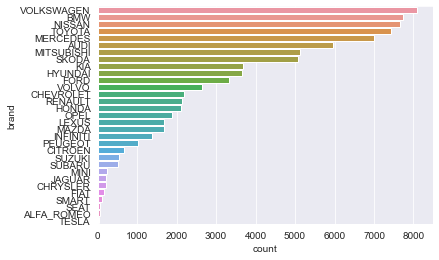

In [68]:
cat_feature_overview(df.brand)

### 2.2.7 fuelType

Total lines: 84213
Data types: object
Total values: 84213
The most frequent value: бензин
The less frequent value: газ
Unique values: 5
Missing values: 0


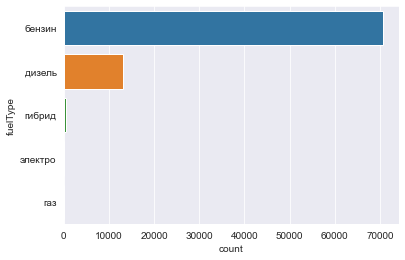

In [69]:
cat_feature_overview(df.fuelType)

In [70]:
#check wether are same the fuel types at the test dataset and training dataset

print('at the test dataset', '\n',test.fuelType.value_counts(), '\n')
print('at the train dataset','\n',train.fuelType.value_counts(),'\n')

at the test dataset 
 бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64 

at the train dataset 
 бензин     50893
дизель      8452
гибрид       244
электро      164
газ            8
Name: fuelType, dtype: int64 



### 2.2.8 engineDisplacement

In [71]:
num_feature_overview(df.engineDisplacement)

Total lines: 84213
Data types: object
Total values: 84213
The most frequent value: 1.6
The less frequent value: 6.5
Unique values: 111
Missing values: 0


In [72]:
df.engineDisplacement.value_counts()

1.6        11888
2.0        11442
2.0 LTR     7391
1.6 LTR     4973
3.0 LTR     3915
           ...  
8.1            2
3.9            2
3.9 LTR        1
5.3 LTR        1
6.5            1
Name: engineDisplacement, Length: 111, dtype: int64

In [73]:
def float_value(feature):
    '''the cleaning function returns the 
    float value's type
    '''
    pattern = re.compile('([^\d.]+)')
    feature = feature.replace(pattern, '')
    oft_value = feature.value_counts(sort=True).keys()[0]
    feature = feature.replace('', oft_value).astype(float, errors = 'raise')
    return feature

In [74]:
df['engineDisplacement'] = float_value(df['engineDisplacement'])

In [75]:
df.engineDisplacement.describe()

count    84213.000000
mean         2.212673
std          0.842872
min          0.000000
25%          1.600000
50%          2.000000
75%          2.500000
max          8.100000
Name: engineDisplacement, dtype: float64

In [76]:
#sampling the relevant engineDisplacement range on train dataset
df.drop(df[(df['sample'] == 1) & (df.engineDisplacement < 0.9) & (df.engineDisplacement > 6)].index, inplace=True)
df[(df['sample'] == 0)].shape

(34686, 24)

c:\users\asyac\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


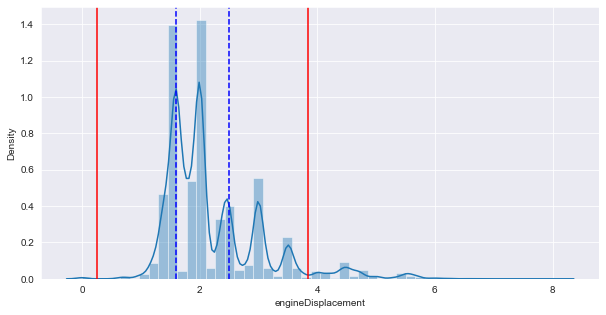

,Q1,Q3,IQR,low_outlier,high_outlier
0,1.6,2.5,0.9,0.25,3.85


In [77]:
#Distribution of the engineDisplacement 
check_iqr(df.engineDisplacement)

In [78]:
#For further modeling seems to be used a log-function of engineDisplacement  feature
df['engineDisplacement _log']=df['engineDisplacement'].apply(lambda x: np.log(x))

In [79]:
num_feature_overview(df.engineDisplacement)

Total lines: 84213
Data types: float64
Total values: 84213
The most frequent value: 2.0
The less frequent value: 6.5
Unique values: 62
Missing values: 0


### 2.2.9 numberOfDoors

In [80]:
num_feature_overview(df.numberOfDoors)

Total lines: 84213
Data types: int64
Total values: 84213
The most frequent value: 5
The less frequent value: 0
Unique values: 5
Missing values: 0


In [81]:
#check the '0' value
df[(df.numberOfDoors == 0)]

,bodyType,brand,color,complectation_dict,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,price,sample,price_log,engineDisplacement _log
16944,кабриолет,MERCEDES,белый,NaN,5.3,32,NaN,бензин,48000,1904,SIMPLEX,5.3 MT (32 л.с.),0,1904,механическая,EUROPEAN,1 владелец,6 лет и 8 месяцев,Оригинал,задний,Правый,0.0,0,0.0,1.667707


In [82]:
df.iloc[16944, 12] = 2#replace the numberOfDoor at cell 16944

In [83]:
df.iloc[16944, 12]#check

2

In [84]:
df.numberOfDoors.describe()

count    84213.000000
mean         4.479807
std          0.681250
min          2.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: numberOfDoors, dtype: float64

(array([ 2244.,     0.,     0.,  2300.,     0.,     0., 32475.,     0.,
            0., 47194.]),
 array([2. , 2.3, 2.6, 2.9, 3.2, 3.5, 3.8, 4.1, 4.4, 4.7, 5. ]),
 <BarContainer object of 10 artists>)

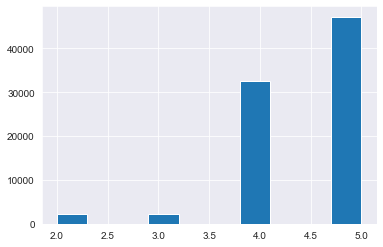

In [85]:
#check

plt.hist(df.numberOfDoors)

### 2.2.10 mileage

In [86]:
num_feature_overview(df.mileage)

Total lines: 84213
Data types: int64
Total values: 84213
The most frequent value: 200000
The less frequent value: 30705
Unique values: 26605
Missing values: 0


In [87]:
df.mileage.describe()

count      84213.000000
mean      158434.981084
std        98190.671099
min            1.000000
25%        88986.000000
50%       147000.000000
75%       210000.000000
max      1000000.000000
Name: mileage, dtype: float64

c:\users\asyac\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


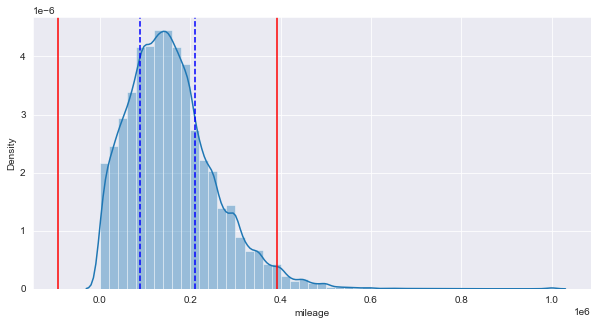

,Q1,Q3,IQR,low_outlier,high_outlier
0,88986.0,210000.0,121014.0,-92535.0,391521.0


In [88]:
check_iqr(df.mileage)

In [89]:
df[(df['mileage']>384000.0)].brand.value_counts()

TOYOTA        396
VOLKSWAGEN    284
AUDI          280
BMW           173
MERCEDES      170
MITSUBISHI    141
NISSAN        141
VOLVO          81
HONDA          79
FORD           67
SKODA          64
OPEL           52
RENAULT        45
LEXUS          44
HYUNDAI        42
CHEVROLET      29
SUBARU         25
MAZDA          24
PEUGEOT        23
KIA            12
CITROEN         8
SUZUKI          5
CHRYSLER        5
JAGUAR          3
SMART           2
FIAT            2
INFINITI        1
SEAT            1
ALFA_ROMEO      1
Name: brand, dtype: int64

In [90]:
#sampling the relevant mileage range on train dataset
df.drop(df[(df['sample'] == 1) & (df.mileage > 391521.0)].index, inplace=True)
df[(df['sample'] == 0)].shape

(34686, 25)

In [91]:
df.shape

(83146, 25)

### 2.2.11 Владельцы

Total lines: 83146
Data types: object
Total values: 83146
The most frequent value: 3 или более
The less frequent value: 2 владельца
Unique values: 7
Missing values: 0


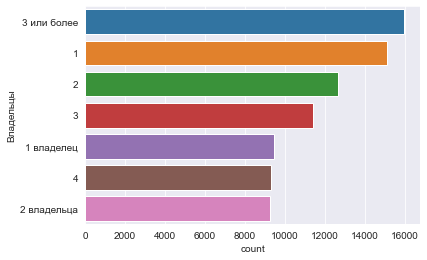

In [92]:
cat_feature_overview(df.Владельцы)

In [93]:
df['Владельцы'] = float_value(df['Владельцы']).astype(int)

<AxesSubplot:xlabel='count', ylabel='Владельцы'>

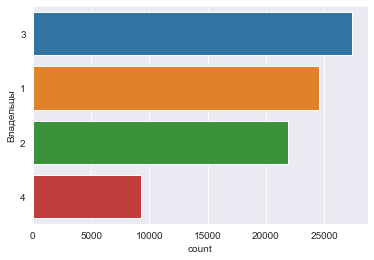

In [94]:
sns.countplot(y = df.Владельцы, order = df.Владельцы.value_counts().index)

### _Statistics by the mileage related to amount of owners_

In [95]:
owner_1 = df[(df['Владельцы']== 1) & (df['mileage']>0)].mileage.describe()
owner_1 

count      24551.000000
mean       98802.964808
std        75714.894345
min            1.000000
25%        42000.000000
50%        84000.000000
75%       138020.000000
max      1000000.000000
Name: mileage, dtype: float64

In [96]:
owner_2 = df[(df['Владельцы']== 2) & (df['mileage']>0)].mileage.describe()
owner_2

count      21920.000000
mean      144851.259352
std        79433.103502
min           87.000000
25%        89000.000000
50%       135000.000000
75%       189000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [97]:
owner_3 = df[(df['Владельцы']== 3) & (df['mileage']>0)].mileage.describe()
owner_3

count      27370.000000
mean      195874.480782
std        90972.095595
min           10.000000
25%       135000.000000
50%       182000.000000
75%       246978.000000
max      1000000.000000
Name: mileage, dtype: float64

In [98]:
owner_4 = df[(df['Владельцы']== 4) & (df['mileage']>0)].mileage.describe()
owner_4

count      9305.000000
mean     203025.947125
std       75434.379848
min          15.000000
25%      150000.000000
50%      197000.000000
75%      250000.000000
max      391150.000000
Name: mileage, dtype: float64

### 2.2.12 vehicleTransmission

Total lines: 83146
Data types: object
Total values: 83146
The most frequent value: автоматическая
The less frequent value: роботизированная
Unique values: 4
Missing values: 0


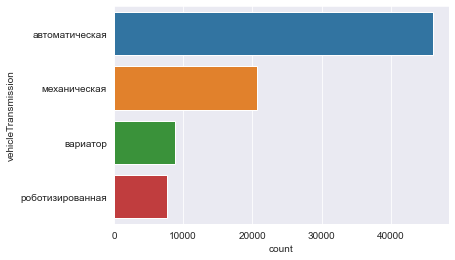

In [99]:
cat_feature_overview(df.vehicleTransmission)

### 2.2.13 Привод

Total lines: 83146
Data types: object
Total values: 83146
The most frequent value: передний
The less frequent value: задний
Unique values: 3
Missing values: 0


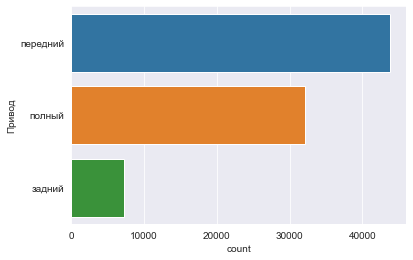

In [100]:
cat_feature_overview(df.Привод)

### 2.2.14 vendor

Total lines: 83146
Data types: object
Total values: 83146
The most frequent value: EUROPEAN
The less frequent value: RUSSIAN
Unique values: 5
Missing values: 0


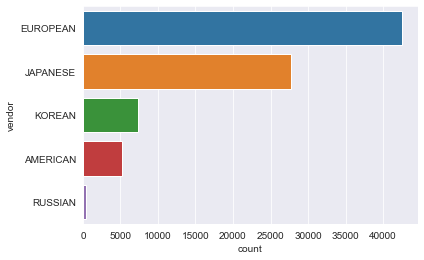

In [101]:
cat_feature_overview(df.vendor)

### 2.2.15 ПТС

Total lines: 83146
Data types: object
Total values: 83145
The most frequent value: Оригинал
The less frequent value: Дубликат
Unique values: 2
Missing values: 1


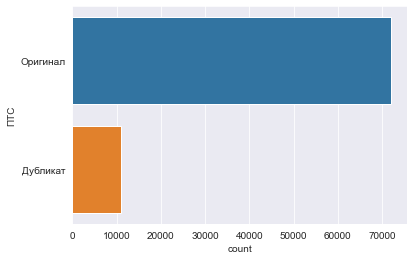

In [102]:
cat_feature_overview(df.ПТС)

In [103]:
#changing the missing value by mode
df.ПТС.fillna(df.ПТС.value_counts().keys()[0], inplace=True)

### 2.2.16 Руль

Total lines: 83146
Data types: object
Total values: 83146
The most frequent value: Левый
The less frequent value: Правый
Unique values: 2
Missing values: 0


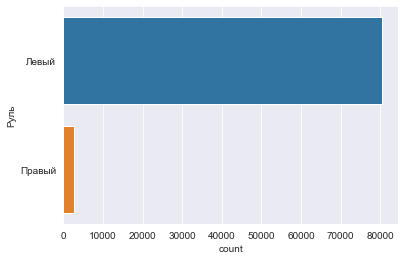

In [104]:
cat_feature_overview(df.Руль)

Due low amounts of the right steering wheel, the feature can be dropped


In [105]:
df.drop(['Руль'], axis=1, inplace=True)

### 2.2.17 name

In [106]:
df.name.value_counts()[:10]

1.6 AT (110 л.с.)        1344
2.0 AT (150 л.с.)        1282
1.6 MT (105 л.с.)         895
1.6 AT (123 л.с.)         891
1.6 MT (102 л.с.)         776
2.0 AT (150 л.с.) 4WD     709
1.4 AMT (150 л.с.)        649
1.4 MT (75 л.с.)          636
1.6 AT (105 л.с.)         627
1.6 MT (110 л.с.)         604
Name: name, dtype: int64

_The contain information is in other columnes_

_It has to be dropped_

In [107]:
df.drop(['name'], axis=1, inplace=True)

### 2.2.18 Владение


In [108]:
df.Владение.isna().sum()

23170

In [109]:
df.Владение.value_counts()

12.0                    47981
1 год и 10 месяцев        209
2 года                    197
1 год                     194
1 год и 1 месяц           193
                        ...  
21 год и 8 месяцев          1
19 лет и 5 месяцев          1
42 года и 10 месяцев        1
21 год и 6 месяцев          1
29 лет и 9 месяцев          1
Name: Владение, Length: 276, dtype: int64

_the biggest part of the values looks as not valid_  

_it has to be dropped_

In [110]:
df.drop(['Владение'], axis=1, inplace=True)

### 2.2.19 model_name

In [111]:
num_feature_overview(df.model_name)

Total lines: 83146
Data types: object
Total values: 83146
The most frequent value: Focus
The less frequent value: GRANVIA
Unique values: 1334
Missing values: 0


In [112]:
#through the changing of the strings to upper letter, the amount of unique values is grouped
df['model_name'] = df.model_name.str.upper()

In [113]:
#most popular model is by each brand
df.groupby(['brand','model_name'])['model_name'].agg(['count']).sort_values(by='count',ascending= False)


,,count
brand,model_name,
SKODA,OCTAVIA,2549
FORD,FOCUS,1702
VOLKSWAGEN,POLO,1460
MITSUBISHI,LANCER,1424
TOYOTA,CAMRY,1397
...,...,...
CHEVROLET,CORSICA,1
TOYOTA,PIXIS VAN,1
MITSUBISHI,LANCER_RALLIART,1


### 2.2.20 color

Total lines: 83146
Data types: object
Total values: 83146
The most frequent value: чёрный
The less frequent value: розовый
Unique values: 16
Missing values: 0


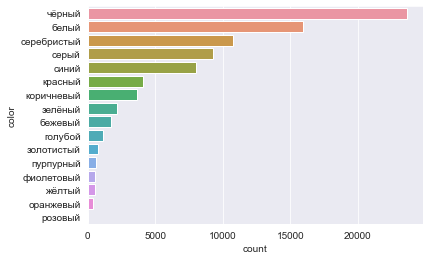

In [114]:
cat_feature_overview(df.color)

In [115]:
#most common color by brands
df.groupby(['brand','color'])['color'].agg(['count']).sort_values(by='count',ascending= False)

count
brand    color            
MERCEDES чёрный       3130
BMW      чёрный       3024
TOYOTA   чёрный       2460
NISSAN   чёрный       2134
AUDI     чёрный       2030
...                    ...
JAGUAR   золотистый      1
CHRYSLER золотистый      1
         коричневый      1
         оранжевый       1
BMW      розовый         1

[451 rows x 1 columns]

### 2.2.21  complectation_dict  &  equipment_dict

 _with nested options dictionary_

_the features look same and they have to be mearged_


In [116]:
print(f'the complectation_dict has {df.complectation_dict.isna().sum()} of missing values')

print(f'the equipment_dict has {df.equipment_dict.isna().sum()} of missing values')

the complectation_dict has 28268 of missing values
the equipment_dict has 9996 of missing values


In [117]:
df['complectation_dict'] = df['complectation_dict'].fillna('No value').astype(str)
df['equipment_dict'] = df['equipment_dict'].fillna('No value').astype(str)

In [118]:

pat = "'id': '0'"
df['complectation_dict'] = df['complectation_dict'].map(lambda x: x if pat not in x else 'No value')

In [119]:
#useful data extracting - string partition method.
cmpl_opt = []
for row in df.complectation_dict:
    try:
        line = row.partition('"available_options":')[-1]
        line = line.partition('"vendor_color')[0]
        cmpl_opt.append(line)
    except:
        cmpl_opt.append('No value')

df['complectation_dict'] = cmpl_opt


In [120]:
df['complectation_dict'] = df['complectation_dict'].apply(clean_smb)

df['complectation_dict']#check

0                                                       []
1                                                       []
2        [heated-wash-system, airbag-passenger, lock, d...
3        [heated-wash-system, airbag-passenger, lock, e...
4                                                       []
                               ...                        
94443                                                   []
94444                                                   []
94445                                                   []
94446                                                   []
94447                                                   []
Name: complectation_dict, Length: 83146, dtype: object

In [121]:
# extracting the options form equipment_dict
df['equipment_dict'] = df['equipment_dict'].apply(clean_smb)

row_lst = []
for row in df.equipment_dict:
    eq_lst = []
    for item in row:
        if item == item:
            key = item.split(':')[0]
            eq_lst.append(key)
        else:
            eq_lst.append('No value')

    row_lst.append(eq_lst)

df['equipment_dict'] = row_lst

In [122]:
df['equipment_dict']#check

0        [engine-proof, tinted-glass, airbag-driver, au...
1        [cruise-control, asr, esp, airbag-driver, isof...
2        [cruise-control, tinted-glass, esp, adaptive-l...
3        [cruise-control, roller-blind-for-rear-window,...
4        [cruise-control, asr, esp, airbag-driver, isof...
                               ...                        
94443    ['cruise-control',  'asr',  'tinted-glass',  '...
94444    ['engine-proof',  'esp',  'airbag-driver',  'u...
94445                                                   []
94446                                                   []
94447    ['electro-window-back',  'alloy-wheel-disks', ...
Name: equipment_dict, Length: 83146, dtype: object

In [123]:
#merging the values from columns equipment_dict and equipment_dict
options = []
for i, j in zip(df.complectation_dict, df.equipment_dict):
    options.append(i+j)
df['options'] = options

In [124]:
df['options']#check

0        [, engine-proof, tinted-glass, airbag-driver, ...
1        [, cruise-control, asr, esp, airbag-driver, is...
2        [heated-wash-system, airbag-passenger, lock, d...
3        [heated-wash-system, airbag-passenger, lock, e...
4        [, cruise-control, asr, esp, airbag-driver, is...
                               ...                        
94443    [, 'cruise-control',  'asr',  'tinted-glass', ...
94444    [, 'engine-proof',  'esp',  'airbag-driver',  ...
94445                                                 [, ]
94446                                                 [, ]
94447    [, 'electro-window-back',  'alloy-wheel-disks'...
Name: options, Length: 83146, dtype: object

In [125]:
#To make a list of most used options
df1 = df
df1 = df.explode('options')

In [126]:

#List of most used options
options_dict = df1.options.value_counts(sort=False)[1:80]
options_lst = options_dict.keys().map(lambda x: x.replace("\'",'').replace(" ", "")).to_list()
options_lst = set(options_lst)


In [127]:
#are sampled only popular options
row_lst = []
for row in df.options:
    opt_lst = []
    for item in row:
        for opt in options_lst:
            if item == opt:
                opt_lst.append(item)
            else:
                continue
    row_lst.append(opt_lst)

In [128]:
#to DataFrame
df['options'] = row_lst
df.options.head(5)

0    [airbag-passenger, computer, seat-transformati...
1    [light-sensor, airbag-passenger, computer, 16-...
2    [airbag-passenger, door-sill-panel, mirrors-he...
3    [airbag-passenger, mirrors-heat, computer, sea...
4    [light-sensor, airbag-passenger, computer, 16-...
Name: options, dtype: object

In [129]:
#plt.figure(figsize=(15,10))
#sns.barplot(options_dict.values, options_dict.index, alpha=0.8)
#plt.title('Most popular options')
#plt.ylabel('Options', fontsize=12)
#plt.xlabel('Number of Occurrences', fontsize=12)
#plt.show()

In [130]:
df.drop(['complectation_dict', 'equipment_dict'], axis=1, inplace=True)

In [131]:
#sort by types
cat_cols = ['bodyType', 'brand', 'color','model_name', 'fuelType', 'vehicleTransmission', 'vendor','Привод', 'options']
num_cols= ['engineDisplacement', 'enginePower','mileage', 'modelDate','productionDate', 'Владельцы','numberOfDoors']
bin_cols = ['ПТС','sample']
target_cols = ['price', 'price_log']


In [132]:
#correlation matrix of train dataset
df_corr = df[(df['sample']== 1)].drop(['sample'], axis=1)
corr = df_corr.corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "8pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Heatmap")\
    .set_precision(2)\
    .set_table_styles(magnify())

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,Владельцы,price,price_log,engineDisplacement _log
engineDisplacement,1.00,0.80,0.07,-0.05,0.10,-0.07,0.05,0.38,0.40,0.98
enginePower,0.80,1.00,-0.12,0.19,0.04,0.16,-0.04,0.55,0.61,0.83
mileage,0.07,-0.12,1.00,-0.65,-0.07,-0.68,0.47,-0.49,-0.59,0.06
modelDate,-0.05,0.19,-0.65,1.00,0.14,0.97,-0.54,0.54,0.75,-0.02
numberOfDoors,0.10,0.04,-0.07,0.14,1.00,0.15,-0.16,0.11,0.15,0.10
productionDate,-0.07,0.16,-0.68,0.97,0.15,1.00,-0.57,0.55,0.75,-0.04
Владельцы,0.05,-0.04,0.47,-0.54,-0.16,-0.57,1.00,-0.36,-0.47,0.04
price,0.38,0.55,-0.49,0.54,0.11,0.55,-0.36,1.00,0.83,0.41
price_log,0.40,0.61,-0.59,0.75,0.15,0.75,-0.47,0.83,1.00,0.44
engineDisplacement _log,0.98,0.83,0.06,-0.02,0.10,-0.04,0.04,0.41,0.44,1.00


the features are highly correlated with each other:
* modelDate, productionDate, mileage, Владельцы, price, 
* enginePower and engineDisplacement 

In [133]:
df[(df['sample'] == 1)].shape

(48460, 21)

In [134]:
df[(df['sample'] == 0)].shape

(34686, 21)

In [135]:
df.isna().sum()

bodyType                   0
brand                      0
color                      0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_name                 0
numberOfDoors              0
productionDate             0
vehicleTransmission        0
vendor                     0
Владельцы                  0
ПТС                        0
Привод                     0
price                      0
sample                     0
price_log                  0
engineDisplacement _log    0
options                    0
dtype: int64

#### Summary by EDA

Using quantitative techniques and visual methods of representation, EDA looks to tell a story about the existing data based on a broad examination of patterns, trends, outliers, and unexpected results.



# 3. Data preprocessing

## 3.1 Significance of continuous variables by ANOVA F test 

<AxesSubplot:title={'center':'Significance of continuous variables by ANOVA F test for all brands'}>

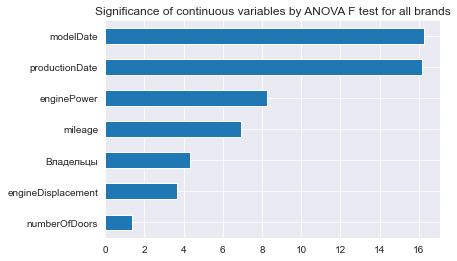

In [136]:
temp_df = df[df['sample']==1]
imp_num = pd.Series(f_classif(temp_df[num_cols], temp_df['price_log'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Significance of continuous variables by ANOVA F test for all brands')

## 3.2 Data encoding

### 3.2.1 Categorical Data Encoding

#### 3.2.2.1 Options

In [137]:
#OneHotEncoding
df1 = pd.DataFrame()
df1 = pd.get_dummies(df['options'].apply(pd.Series), prefix='', prefix_sep='', dummy_na=True).sum(level=0, axis=1)
df1.drop(['nan'], axis=1, inplace=True)
df1.head(3)

,16-inch-wheels,17-inch-wheels,21-inch-wheels,airbag-passenger,airbag-side,audiosystem-cd,auto-cruise,automatic-lighting-control,black-roof,blind-spot,bluetooth,body-mouldings,climate-control-2,collision-prevention-assist,combo-interior,computer,door-sill-panel,electro-trunk,electronic-gage-panel,feedback-alarm,folding-front-passenger-seat,front-camera,front-centre-armrest,gbo,immo,lane-keeping-assist,leather,light-cleaner,light-interior,light-sensor,mirrors-heat,multi-wheel,multizone-climate-control,paint-metallic,park-assist-r,power-child-locks-rear-doors,power-latching-doors,programmed-block-heater,rain-sensor,rear-seat-heat-vent,remote-engine-start,seat-memory,seat-transformation,seats-2,seats-6,seats-7,seats-9,start-button,steering-wheel-gear-shift-paddles,traffic-sign-recognition,turnbuckle,wheel-configuration1,wheel-heat,audiosystem,dha,folding-tables-rear,parktronik,vsm,24-inch-wheels,climate-control-3,laminated-safety-glass,2C5,S7N,UI4,364,448,500,772,RVR,P29,03B,6NQ,B16
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,2,2,2,0,0,0,0,0,2,1,0,1,2,2,0,0,0,0,0,2,0,2,0,0,1,0,2,2,1,0,0,1,1,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [138]:
cat_cols.remove('options')


In [139]:
#Lable encoding
labelencoder = LabelEncoder()
for col in cat_cols:
    df1[col] = labelencoder.fit_transform(df[col].astype(str))


### 3.2.2 Binary Data Encoding

In [140]:
#Lable encoding
labelencoder = LabelEncoder()
df1['ПТС'] = labelencoder.fit_transform(df['ПТС'])

In [141]:
#Adding to df1 the 'sample' column
df1['sample'] = df['sample'].values

### 3.2.3 Numerical Data Type's columns

In [142]:
#Appending the numerical columns into df1
df1[num_cols] = df[num_cols].values

In [143]:
df1[target_cols] = df[target_cols].values

In [144]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83146 entries, 0 to 94447
Data columns (total 92 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   16-inch-wheels                     83146 non-null  uint8  
 1   17-inch-wheels                     83146 non-null  uint8  
 2   21-inch-wheels                     83146 non-null  uint8  
 3   airbag-passenger                   83146 non-null  uint8  
 4   airbag-side                        83146 non-null  uint8  
 5   audiosystem-cd                     83146 non-null  uint8  
 6   auto-cruise                        83146 non-null  uint8  
 7   automatic-lighting-control         83146 non-null  uint8  
 8   black-roof                         83146 non-null  uint8  
 9   blind-spot                         83146 non-null  uint8  
 10  bluetooth                          83146 non-null  uint8  
 11  body-mouldings                     83146 non-null  uin

In [145]:
df1[(df1['sample'] == 0)].shape

(34686, 92)

### Dataset separation on traininig and testing parts by sample mark 

In [146]:
df1.drop(['price'], axis=1, inplace=True)

y = df1[(df1['sample']==1)].price_log
X = df1[(df1['sample']==1)].drop(['price_log'], axis=1)

X_sub = df1[(df1['sample']==0)].drop(['price_log'], axis=1)


In [147]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# 4. Machine Learning Model

## 4.1 Exploration ML Models

In [148]:
#Model Random Forest 
reg_forest = RandomForestRegressor(n_estimators = 10, random_state = RANDOM_SEED)
reg_forest.fit(X_train, y_train)
y_pred = reg_forest.predict(X_val)

In [149]:
#Accuracy metrics
metrics_func(y_val, y_pred)

MAE Mean Absolute Error 0.14275459362498527
MAPE  Mean Absolute Percentage Error 1.0789583331203338%
SMAPE Symmetric Mean Absolute Percentage Error 1.078891359650001%
MSE Mean Squared Error 0.04762752871016415
RMSE Root Mean Squared Error 0.2182373219918265
R_2 Coefficient of determination 0.9407091431599184


<AxesSubplot:>

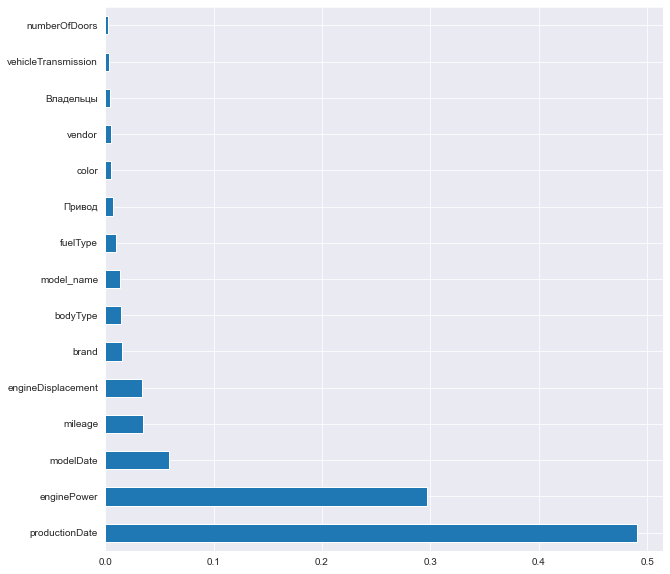

In [150]:
#Analysis of variables by importance (random forest model)
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(reg_forest.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')


In [151]:
df1.isna().sum()

16-inch-wheels      0
17-inch-wheels      0
21-inch-wheels      0
airbag-passenger    0
airbag-side         0
                   ..
modelDate           0
productionDate      0
Владельцы           0
numberOfDoors       0
price_log           0
Length: 91, dtype: int64

In [152]:
# Linear Regeression
y_train = df1.price_log.values   
X_train = df1.drop(['price_log'], axis=1)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_val)

In [153]:
#Accuracy metrics
metrics_func(y_val, y_pred)

MAE Mean Absolute Error 0.3605995601419255
MAPE  Mean Absolute Percentage Error 2.685525237327818%
SMAPE Symmetric Mean Absolute Percentage Error 2.6727107920802466%
MSE Mean Squared Error 0.21433996954482085
RMSE Root Mean Squared Error 0.46296864855497594
R_2 Coefficient of determination 0.7331711135648882


In [154]:
#Cross-validation for Lrg
lin_reg = LinearRegression()
lin_reg_res = cross_val_score(lin_reg, X, y, cv=5, scoring='neg_mean_squared_error')
lin_reg_res 

array([-0.14339827, -0.09123677, -0.13246286, -0.12880924, -0.1510435 ])

In [155]:
np.mean(np.sqrt(-1*lin_reg_res))

0.35844631188972687

In [156]:
#Cross-validation for reg_forest
reg_forest = RandomForestRegressor(n_estimators = 10)
reg_forest_res = cross_val_score(reg_forest, X, y, cv=5, scoring='neg_mean_squared_error')
reg_forest_res 

array([-0.14250013, -0.06588871, -0.11930435, -0.11158904, -0.16590618])

In [157]:
np.mean(np.sqrt(-1*reg_forest_res))

0.34418994914017886

### _the accurancy at linear Regression metrics has been worsened with compare to Random Forest Model_

## 4.2 Hyperparameters tuning¶

In [158]:
reg_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [159]:
param_grid = {
    'max_depth' : [5, 10, 15],
    'n_estimators': [1, 5, 10, 15]
}

In [160]:
#Random Forest Model with HP
reg_forest = RandomForestRegressor(random_state = RANDOM_SEED)
grid_cv = GridSearchCV(reg_forest, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [1, 5, 10, 15]},
             scoring='neg_mean_squared_error')

In [161]:
grid_cv.best_params_ #best params from Cross-Validation of X_train

{'max_depth': 15, 'n_estimators': 15}

In [162]:
grid_cv.best_score_

-0.06569397681058589

In [163]:
grid_cv.best_estimator_

RandomForestRegressor(max_depth=15, n_estimators=15, random_state=42)

In [164]:
#Applying the grid_cv to the RandomForestRegressor
y_pred = grid_cv.predict(X_val)


In [165]:
#Accuracy metrics
metrics_func(y_val, y_pred)

MAE Mean Absolute Error 0.0987750972738793
MAPE  Mean Absolute Percentage Error 0.7478098458197838%
SMAPE Symmetric Mean Absolute Percentage Error 0.7471504820485638%
MSE Mean Squared Error 0.020173535668691317
RMSE Root Mean Squared Error 0.14203357232954228
R_2 Coefficient of determination 0.974886242312308


In [166]:
### gradient boosting model
gbr = GradientBoostingRegressor(n_estimators=250)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_val)


In [167]:
metrics_func(y_val, y_pred)

MAE Mean Absolute Error 0.1621835625206341
MAPE  Mean Absolute Percentage Error 1.2180906987249562%
SMAPE Symmetric Mean Absolute Percentage Error 1.2166321503750024%
MSE Mean Squared Error 0.05374200917468791
RMSE Root Mean Squared Error 0.23182322828976373
R_2 Coefficient of determination 0.9330973103461746


### _the accurancy at gradient boosting model has been worsened with compare to Random Forest Model also_

In [168]:
#Bagging Regression model with Random Forest Model
bgr_rf = BaggingRegressor(reg_forest, n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED)
bgr_rf.fit(X_train, y_train)
y_pred = bgr_rf.predict(X_val)
metrics_func(y_val, y_pred)


MAE Mean Absolute Error 0.08014177736578391
MAPE  Mean Absolute Percentage Error 0.6063540658640365%
SMAPE Symmetric Mean Absolute Percentage Error 0.6061960335734436%
MSE Mean Squared Error 0.0167620819868322
RMSE Root Mean Squared Error 0.12946845942866625
R_2 Coefficient of determination 0.9791331141812764


In [169]:
models = [RandomForestRegressor(max_depth=15, n_estimators=15, random_state=RANDOM_SEED),
         BaggingRegressor(reg_forest, n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED)]

def stacking_model_predict(d_models, d_X_train, d_y_train, d_X_val):
    d_df = pd.DataFrame()
    for model_ in d_models:
        model_.fit(d_X_train, d_y_train)
        y_pred = model_.predict(d_X_val)
        d_df[str(model_)[:6]] = np.exp(y_pred)  
    metrics_func(y_val, y_pred)
    return d_df


stacking_model_predict(models, X_train, y_train, X_val)

MAE Mean Absolute Error 0.08014177736578391
MAPE  Mean Absolute Percentage Error 0.6063540658640365%
SMAPE Symmetric Mean Absolute Percentage Error 0.6061960335734436%
MSE Mean Squared Error 0.0167620819868322
RMSE Root Mean Squared Error 0.12946845942866625
R_2 Coefficient of determination 0.9791331141812764


,Random,Baggin
0,4.349517e+05,4.365358e+05
1,4.133522e+06,4.112188e+06
2,1.099799e+06,1.176024e+06
3,2.562309e+06,2.503584e+06
4,8.321835e+05,8.947885e+05
...,...,...
9687,7.486791e+05,7.426929e+05
9688,6.158620e+05,6.473567e+05
9689,1.036233e+06,8.752553e+05
9690,1.493132e+06,1.436229e+06


# 5.Submission

In [170]:
y_train = df1[(df1['sample']==1)].price_log.values            
X_train = df1[(df1['sample']==1)].drop(['price_log'], axis=1)

X_sub = df1[(df1['sample']==0)].drop(['price_log'], axis=1)

In [171]:
models = [RandomForestRegressor(max_depth=15, n_estimators=15, random_state=RANDOM_SEED),
         BaggingRegressor(ExtraTreeRegressor(random_state=RANDOM_SEED), random_state=RANDOM_SEED)]

def stacking_model_predict(d_models, d_X_train, d_y_train, d_X_test):
    d_df = pd.DataFrame()
    for model_ in d_models:
        model_.fit(d_X_train, d_y_train)
        y_pred = model_.predict(d_X_test)
        d_df[str(model_)[:6]] = np.round(np.exp(y_pred)/10000,2)*10000
        d_df['price'] = d_df.mean(axis=1)
    return d_df

submit['price'] = stacking_model_predict(models, X_train, y_train, X_sub)

In [172]:
submit

,sell_id,price
0,1100575026,709000.0
1,1100549428,1107800.0
2,1100658222,1027600.0
3,1100937408,808000.0
4,1101037972,1055300.0
...,...,...
34681,1101369263,1130100.0
34682,1101369581,2836800.0
34683,1101364889,293100.0
34684,1101362518,1554700.0


In [173]:
submit.to_csv(f'submission.csv', index=False)